# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Mapping Groupes de produits </center>

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import re
import random
from Preprocessing_treetagger_v2 import *
import gensim.models as models
from gensim import corpora
from time import time


pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

chemin = "C:/Users/JN/Desktop/Arbeit/fil_rouge/github/Data/"
chemin_val = "/Users/valentinphetchanpheng/Documents/MS BGD Telecom ParisTech/Projet Fil Rouge/"

## Importation des données et reformatage

In [2]:
# Importation des données vendeurs
path_train_set = "/Users/valentinphetchanpheng/Downloads/INNOSCAPE-master 2/Data/Train_set.xlsx"
df_seller_origin = pd.read_excel(path_train_set)

# Selection colonnes pertinentes
columns_to_keep = ['productfamily_seller',
                   'productseller_name',
                   'Product_category_1_innoscape',
                   'Product_category_2_innoscape',
                   'Product_family_innoscape']

df_seller = df_seller_origin[columns_to_keep]


In [3]:
# Importation des données ref innoscape
df_ref = pd.read_excel("/Users/valentinphetchanpheng/Downloads/INNOSCAPE-master 2/Data/Train_set.xlsx", sheet_name='Feuil1')
df_ref = df_ref.drop_duplicates()
df_ref['label'] = df_ref.innoscape_ref_prodcategory1_seller + " " + df_ref.innoscape_ref_prodcategory2_seller + " " + df_ref.innoscape_ref_productfamily_seller
columns_to_keep = ['label']
df_ref = df_ref[columns_to_keep]
cat_innoscape = df_ref.label.unique()


In [4]:
df_seller = df_seller.dropna(how='all', subset=['productfamily_seller',
                                                'productseller_name',
                                                'Product_category_2_innoscape',
                                                'Product_family_innoscape'])
df_seller = df_seller.fillna("")

In [5]:
# Label
df_label = df_seller['Product_category_1_innoscape'] + " " + df_seller['Product_category_2_innoscape'] + " " + df_seller['Product_family_innoscape'] 
df_label = pd.Series.to_frame(df_label)
df_label.columns = ['label']
df_label
cat = df_label.label.unique()


## Preprocessing

In [6]:
# Caractères spéciaux
dico1 = {",":" ", "'":" ", ";":" ", ":":" ", "\?":" ", "!":" ", "\.":'', "  ":" ", "  ":" ",
         "\(":"","\)":"","\[":"","\]":"","-":" ","\+":"","/":"","\*":"","–":" ",
         "&":"et"}

# Caractères avec accents
dico2 = {'à':'a','â':'a','ä':'a',
              'é':'e','è':'e','ê':'e','ë':'e',
              'ï':'i','î':'i',
              'ô':'o','ö':'o',
              'ù':'u','û':'u',
              'ç':'c'}

In [7]:
# Stop words & marques
stop_words = {'a',
             'ai',
             'aie',
             'aient',
             'aies',
             'ait',
             'as',
             'au',
             'aura',
             'aurai',
             'auraient',
             'aurais',
             'aurait',
             'auras',
             'aurez',
             'auriez',
             'aurions',
             'aurons',
             'auront',
             'aux',
             'avaient',
             'avais',
             'avait',
             'avec',
             'avez',
             'aviez',
             'avions',
             'avons',
             'ayant',
             'ayante',
             'ayantes',
             'ayants',
             'ayez',
             'ayons',
             'c',
             'ce',
             'ces',
             'd',
             'dans',
             'de',
             'des',
             'du',
             'elle',
             'en',
             'es',
             'est',
             'et',
             'eu',
             'eue',
             'eues',
             'eurent',
             'eus',
             'eusse',
             'eussent',
             'eusses',
             'eussiez',
             'eussions',
             'eut',
             'eux',
             'eûmes',
             'eût',
             'eûtes',
             'furent',
             'fus',
             'fusse',
             'fussent',
             'fusses',
             'fussiez',
             'fussions',
             'fut',
             'fûmes',
             'fût',
             'fûtes',
             'il',
             'j',
             'je',
             'l',
             'la',
             'le',
             'leur',
             'lui',
             'm',
             'ma',
             'mais',
             'me',
             'mes',
             'moi',
             'mon',
             'même',
             'n',
             'ne',
             'nos',
             'notre',
             'nous',
             'on',
             'ont',
             'ou',
             'par',
             'pas',
             'pour',
             'qu',
             'que',
             'qui',
             's',
             'sa',
             'se',
             'sera',
             'serai',
             'seraient',
             'serais',
             'serait',
             'seras',
             'serez',
             'seriez',
             'serions',
             'serons',
             'seront',
             'ses',
             'soient',
             'sois',
             'soit',
             'sommes',
             'son',
             'sont',
             'soyez',
             'soyons',
             'suis',
             'sur',
             't',
             'ta',
             'te',
             'tes',
             'toi',
             'ton',
             'tu',
             'un',
             'une',
             'vos',
             'votre',
             'vous',
             'y',
             'à',
             'étaient',
             'étais',
             'était',
             'étant',
             'étante',
             'étantes',
             'étants',
             'étiez',
             'étions',
             'été',
             'étée',
             'étées',
             'étés',
             'êtes',
             ',',
             '(',
             ')',
             '[',
             ']',
             '-',
             '/',
             '+',
             '*',
             '{',
             '}',
             '!',
             ';',
             ':',
             '?',
             '.',
             '&'
             }


marques =  set(open('marques.txt').read().split())

stop_words = stop_words.union(marques)

In [8]:
# Preprocessing ref innoscape
t0 = time()

df_ref = preprocessing(df_ref, df_ref.columns, dico1, dico2, stop_words, '/Users/valentinphetchanpheng/Downloads/treetagger')

print("preprocessing ref done in %0.3fs" % (time() - t0))


preprocessing ref done in 1.380s


In [9]:
df_ref.head(5)

label  \
0     Terrasse et jardin Aménagement Abris de jardin   
1  Terrasse et jardin Aménagement Accessoires ame...   
2  Chauffage et Plomberie Chauffe eau et ballon d...   
3  Chauffage et Plomberie Production d énergie et...   
4  Matériaux et menuiserie Toiture charpente et b...   

                                    label_treetagger  \
0     terrasser et jardin amenagement abri de jardin   
1  terrasser et jardin amenagement accessoire ame...   
2  chauffage et plomberie chauffer eau et ballon ...   
3  chauffage et plomberie production d energie et...   
4  materiau|materiaux et menuiserie toiturer char...   

                                         label_clean  
0             [amenagement, jardin, abri, terrasser]  
1  [accessoire, produit, jardin, terrasser, entre...  
2  [accessoire, eau, chauffer, chauffage, plomber...  
3  [energie, accessoire, eau, renouvelable, chauf...  
4  [accessoire, charpente, toiturer, menuiserie, ...

In [10]:
# Preprocessing données vendeur
t0 = time()

list_col = ['productfamily_seller', 'productseller_name', 'Product_category_2_innoscape']
df_seller = preprocessing(df_seller, list_col, dico1, dico2, stop_words, '/Users/valentinphetchanpheng/Downloads/treetagger')

print("preprocessing seller done in %0.3fs" % (time() - t0))


preprocessing seller done in 13.850s


In [11]:
df_seller.head(5)

productfamily_seller                                 productseller_name  \
0   Colles à carrelage  SikaCeram Xtra   Colle à carrelage intérieur e...   
1   Colles à carrelage  SikaCeram Joint Fin   Mortier pour joint de ca...   
2   Colles à carrelage  SikaCeram Joint Dallage extérieur   Mortier jo...   
3   Colles à carrelage  Colle à carrelage en pâte spéciale carreaux et...   
4               Mastic              Colle mastic pour joints d étanchéité   

  Product_category_1_innoscape Product_category_2_innoscape  \
0      Matériaux et Menuiserie   Colles Adhésifs Etanchéité   
1      Matériaux et Menuiserie   Colles Adhésifs Etanchéité   
2      Matériaux et Menuiserie   Colles Adhésifs Etanchéité   
3      Matériaux et Menuiserie   Colles Adhésifs Etanchéité   
4      Matériaux et Menuiserie   Colles Adhésifs Etanchéité   

    Product_family_innoscape productfamily_seller_treetagger  \
0  Mastic, colle, étanchéité               colle a carrelage   
1  Mastic, colle, étanchéité               colle a carrelage   
2  Mastic, colle, étanchéité               colle a carrelage   
3  Mastic, colle, étanchéité               colle a carrelage   
4  Mastic, colle, étanchéité                          mastic   

                       productseller_name_treetagger  \
0  sikaceram xtra coller a carrelage interieur et...   
1  sikaceram joindre fin mortier pour joint de ca...   
2  sikaceram joindre dallage exterieur mortier jo...   
3  colle a carrelage en pate special carreau et p...   
4               colle mastic pour joint d etancheite   

  Product_category_2_innoscape_treetagger productfamily_seller_clean  \
0                colle adhesif etancheite         [colle, carrelage]   
1                colle adhesif etancheite         [colle, carrelage]   
2                colle adhesif etancheite         [colle, carrelage]   
3                colle adhesif etancheite         [colle, carrelage]   
4                colle adhesif etancheite                   [mastic]   

                            productseller_name_clean  \
0  [coller, interieur, max, carrelage, carreau, e...   
1  [joindre, mortier, fin, gacher, interieur, cen...   
2  [largeur, joindre, mortier, dallage, carrelage...   
3  [basic, carrelage, carreau, plaquette, pate, c...   
4                 [colle, etancheite, joint, mastic]   

  Product_category_2_innoscape_clean  
0       [colle, adhesif, etancheite]  
1       [colle, adhesif, etancheite]  
2       [colle, adhesif, etancheite]  
3       [colle, adhesif, etancheite]  
4       [colle, adhesif, etancheite]

In [12]:
# On garde quelques colonnes pour les données vendeurs
cols_to_keep = ['productfamily_seller_clean',
                'productseller_name_clean',
                'Product_category_2_innoscape_clean']

df2 = df_seller[cols_to_keep]
df2.rename(columns={'productfamily_seller_clean':"prod_fam",
                'Product_category_2_innoscape_clean':'cat4',
                'productseller_name_clean':'description'}, inplace=True)

In [13]:
# Seller
df2.head(5)

prod_fam                                        description  \
0  [colle, carrelage]  [coller, interieur, max, carrelage, carreau, e...   
1  [colle, carrelage]  [joindre, mortier, fin, gacher, interieur, cen...   
2  [colle, carrelage]  [largeur, joindre, mortier, dallage, carrelage...   
3  [colle, carrelage]  [basic, carrelage, carreau, plaquette, pate, c...   
4            [mastic]                 [colle, etancheite, joint, mastic]   

                           cat4  
0  [colle, adhesif, etancheite]  
1  [colle, adhesif, etancheite]  
2  [colle, adhesif, etancheite]  
3  [colle, adhesif, etancheite]  
4  [colle, adhesif, etancheite]

In [14]:
# Concaténation du product family name + cat 4 + description : document
df2['prod_info'] = df2.prod_fam + df2.cat4 +df2.description
df2['prod_info'] = df2['prod_info'].apply(lambda x: ' '.join(x))
df2.head(5)

prod_fam                                        description  \
0  [colle, carrelage]  [coller, interieur, max, carrelage, carreau, e...   
1  [colle, carrelage]  [joindre, mortier, fin, gacher, interieur, cen...   
2  [colle, carrelage]  [largeur, joindre, mortier, dallage, carrelage...   
3  [colle, carrelage]  [basic, carrelage, carreau, plaquette, pate, c...   
4            [mastic]                 [colle, etancheite, joint, mastic]   

                           cat4  \
0  [colle, adhesif, etancheite]   
1  [colle, adhesif, etancheite]   
2  [colle, adhesif, etancheite]   
3  [colle, adhesif, etancheite]   
4  [colle, adhesif, etancheite]   

                                           prod_info  
0  colle carrelage colle adhesif etancheite colle...  
1  colle carrelage colle adhesif etancheite joind...  
2  colle carrelage colle adhesif etancheite large...  
3  colle carrelage colle adhesif etancheite basic...  
4  mastic colle adhesif etancheite colle etanchei...

## TF-IDF

### Gensim

In [15]:
# TF-IDF avec gensim
texts = [[word for word in document.lower().split()] for document in df2['prod_info']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
vectors = tfidf[corpus]

In [16]:
# Exemple tf-idf pour chaque mot du 99ème document du corpus
vectors[100]

[(80, 0.0786797153869158),
 (85, 0.42739815086163463),
 (121, 0.2758428407936068),
 (219, 0.3083641126542753),
 (246, 0.17664336938965228),
 (350, 0.2467982067319573),
 (353, 0.2901329460274513),
 (410, 0.4579201090477067),
 (411, 0.5039667020749218)]

In [17]:
# Feature 148 correspond au mot chauffage dans le corpus
dictionary.get(148)

'chauffage'

## Embeddings

### LSI : Reduction Dimension

In [18]:
# Embedding lsi en ne gardant que les 200 topics correspondant aux valeurs propres les plus élevées

t1 = time()

lsi2 = models.LsiModel(vectors, id2word=dictionary, num_topics=200)
corpus_lsi2 = lsi2[vectors]

print("lsi with dim = 200 done in %0.3fs" % (time() - t1))

lsi with dim = 200 done in 0.713s


In [1]:
# Axes factoriels
lsi2.show_topics()

NameError: name 'lsi2' is not defined

In [20]:
# tfidf dans l'embedding issu de la lsi (n_dim = 200)
data_lsi2 = lsi2[vectors]

In [21]:
df2.head(5)

prod_fam                                        description  \
0  [colle, carrelage]  [coller, interieur, max, carrelage, carreau, e...   
1  [colle, carrelage]  [joindre, mortier, fin, gacher, interieur, cen...   
2  [colle, carrelage]  [largeur, joindre, mortier, dallage, carrelage...   
3  [colle, carrelage]  [basic, carrelage, carreau, plaquette, pate, c...   
4            [mastic]                 [colle, etancheite, joint, mastic]   

                           cat4  \
0  [colle, adhesif, etancheite]   
1  [colle, adhesif, etancheite]   
2  [colle, adhesif, etancheite]   
3  [colle, adhesif, etancheite]   
4  [colle, adhesif, etancheite]   

                                           prod_info  
0  colle carrelage colle adhesif etancheite colle...  
1  colle carrelage colle adhesif etancheite joind...  
2  colle carrelage colle adhesif etancheite large...  
3  colle carrelage colle adhesif etancheite basic...  
4  mastic colle adhesif etancheite colle etanchei...

In [22]:
# Création de la matrice de features X et des labels Y
from gensim import matutils
X = pd.DataFrame(matutils.corpus2csc(data_lsi2).T.todense(), index=df2.index.values)

# Dictionnaire des catégories/labels
label_dict = dict(zip(cat, range(len(cat))))

# Dictionnaire des topics/axes factoriels 
topic_dict = dict(lsi2.show_topics())

print("Dimension X :", X.shape)

Dimension X : (1971, 200)


In [23]:
# Catégorie labels
Y = df_label['label'].apply(lambda x: label_dict[x])

print("Dimension Y :", Y.shape)

Dimension Y : (1971,)


## Models

In [24]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Semi-supervised : label spreading

In [25]:
# Methode 1 : train test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.0, random_state=0)

In [27]:
# Méthode 2
import random
random_index = np.random.permutation(X.index)
X = X.reindex(random_index)
Y = Y.reindex(random_index)

In [26]:
X = pd.concat([Xtrain, Xtest])

y_train = pd.DataFrame(Ytrain)
y_test = pd.DataFrame(Ytest)
Y = pd.concat([y_train, y_test])

NameError: name 'Xtrain' is not defined

In [30]:
n_total_samples = len(Y)
n_labeled_points = 500

indices = X.index 
unlabeled_index = indices[n_labeled_points:]

In [31]:
# #############################################################################
# Shuffle everything around
ytrain = Y.copy()
ytrain.loc[unlabeled_index] = -1
ytrain = pd.DataFrame(ytrain)
#ytrain.rename(columns={'0':'label'}, inplace=True)

In [32]:
# #############################################################################

from sklearn.semi_supervised import label_propagation
from sklearn.metrics import confusion_matrix, classification_report

for k in np.arange(0.1,20,1):
    # Learn with LabelSpreading
    lp_model = label_propagation.LabelSpreading(kernel='rbf', gamma=k, alpha=0.2, max_iter = 50) #gamma=0.25, max_iter=5)
    lp_model.fit(X, np.ravel(ytrain))
    predicted_labels = lp_model.transduction_[unlabeled_index]
    true_labels = Y[unlabeled_index]
    score = accuracy_score(true_labels, predicted_labels)

    print(f'Gamma = {k} & accuracy = {score}')
    #cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
    #print("Confusion matrix")
    #print(cm)

Gamma = 0.1 & accuracy = 0.14479945615227735
Gamma = 1.1 & accuracy = 0.14479945615227735
Gamma = 2.1 & accuracy = 0.13936097892590074
Gamma = 3.1 & accuracy = 0.10469068660774983
Gamma = 4.1 & accuracy = 0.07953772943575799
Gamma = 5.1 & accuracy = 0.06798096532970768
Gamma = 6.1 & accuracy = 0.05302515295717199
Gamma = 7.1 & accuracy = 0.046227056424201225
Gamma = 8.1 & accuracy = 0.04010876954452753
Gamma = 9.1 & accuracy = 0.03942895989123046
Gamma = 10.1 & accuracy = 0.038069340584636305
Gamma = 11.1 & accuracy = 0.038069340584636305
Gamma = 12.1 & accuracy = 0.037389530931339225
Gamma = 13.1 & accuracy = 0.037389530931339225
Gamma = 14.1 & accuracy = 0.036709721278042146
Gamma = 15.1 & accuracy = 0.036709721278042146
Gamma = 16.1 & accuracy = 0.036709721278042146
Gamma = 17.1 & accuracy = 0.037389530931339225
Gamma = 18.1 & accuracy = 0.038069340584636305
Gamma = 19.1 & accuracy = 0.038069340584636305


### SVM

In [25]:
from sklearn import linear_model
from sklearn.svm import LinearSVC

t1 = time()

clf_svm = LinearSVC()
#clf_svm = linear_model.SGDClassifier(alpha=1e-3, max_iter=2000)
clf_svm.fit(X_train, y_train)
score = accuracy_score(clf_svm.predict(X_test), y_test)

print("Training SVM done in %0.3fs" % (time() - t1))
print('Score = ', score)

Training SVM done in 0.916s
Score =  0.8911392405063291


### RandomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier

t1 = time()

clf_rf = RandomForestClassifier(max_depth=100, random_state=2, n_estimators=1000)
clf_rf.fit(X_train, y_train)
score = accuracy_score(clf_rf.predict(X_test), y_test)

print("Training done in %0.3fs" % (time() - t1))
print('Score Random Forest = ', score)

Training done in 41.532s
Score =  0.9088607594936708


### ExtraTree

In [25]:
# Features Importance
from sklearn.ensemble import RandomForestClassifier

t1 = time()

clf_rf = RandomForestClassifier(n_estimators=1000)
clf_rf.fit(X_train, y_train)

print("Training done in %0.3fs" % (time() - t1))

dict_feature_importance = {'feature': X_train.columns.values, 'importance': clf_rf.feature_importances_}
feature_importances_lat = pd.DataFrame(data=dict_feature_importance).sort_values('importance', ascending=False)


Training done in 42.575s


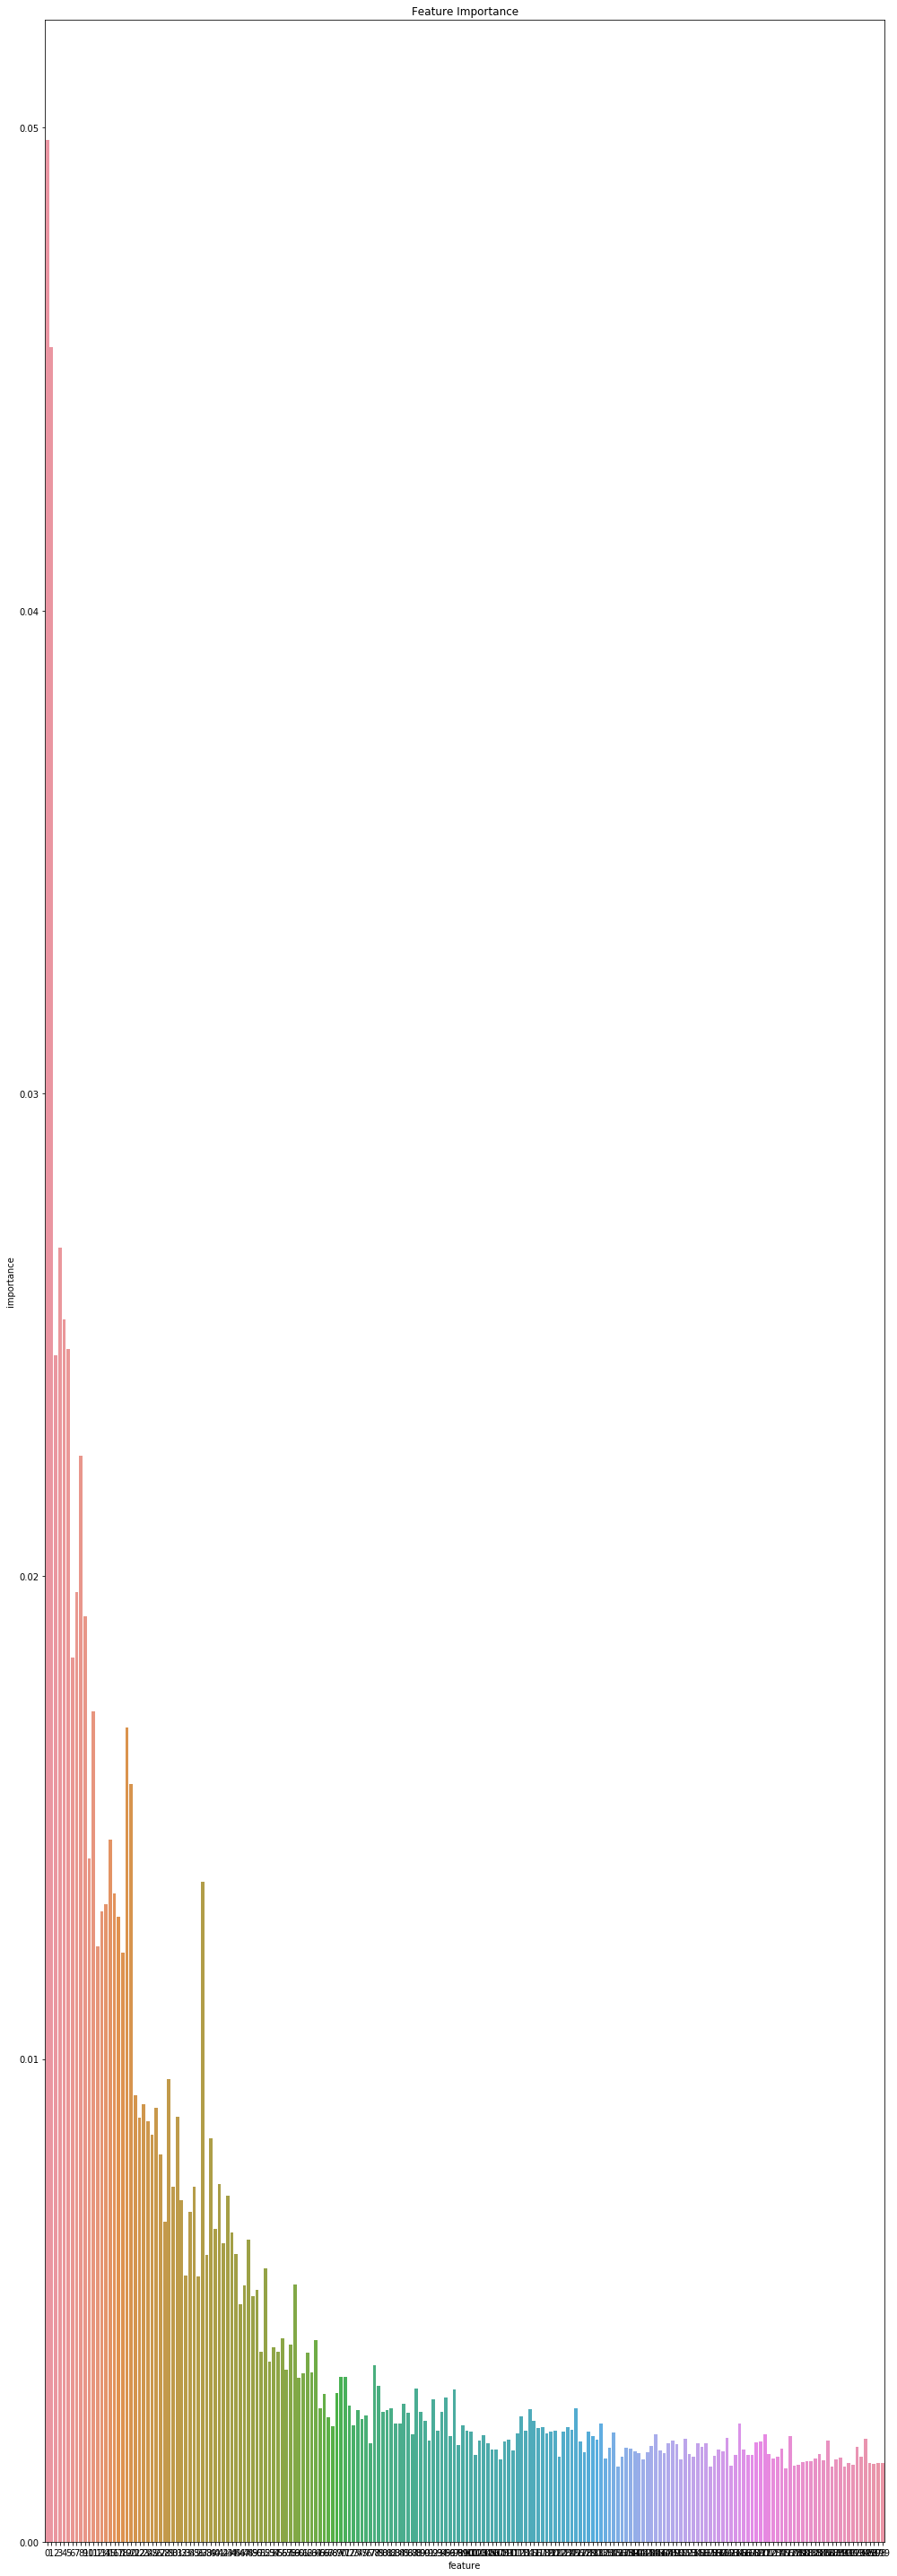

In [28]:
# Calcul des Features Importances pour la latitude
plt.figure(figsize=(14,40))
sns.barplot(x="feature",
            y="importance",
            data=feature_importances_lat.sort_values(by="importance",
                                                     ascending=False))
plt.title('Feature Importance')
plt.tight_layout()

In [27]:
from sklearn.ensemble import ExtraTreesClassifier

t1 = time()

clf_ex = ExtraTreesClassifier(max_depth=100, random_state=2, n_estimators=2000)
clf_ex.fit(X_train, y_train)
y_predict = clf_ex.predict(X_test)
score = accuracy_score(y_predict, y_test)

print("Training done in %0.3fs" % (time() - t1))
print('Score Extra Tree = ', score)

Training done in 24.980s
Score Extra Tree =  0.9113924050632911


In [28]:
# Check résultats label prédit dans dataframe
label_predict = [key for i in y_predict for key, value in label_dict.items() if value == i]
true_label = [[key for key, value in label_dict.items() if value == i] for i in y_test]

df_test = df_seller[['productfamily_seller', 'productseller_name', 'Product_category_2_innoscape', 'Product_family_innoscape']]
df_test = df_test.loc[X_test.index]
df_test['label_predit'] = label_predict
df_test

productfamily_seller  \
752                Sécateur   Cisaille   Coupe branches   
765                                  Equipement piscine   
1655                  Disque à tronçonner pour meuleuse   
1252                           Protection pour végétaux   
1102     Etanchéité des fondations mur enterré et dalle   
694                                             Adhésif   
70             Aspirateurs balais et balais électriques   
1420                               Embout pour visseuse   
56                                      Stickers muraux   
1117  Habillage de sous toiture sous face et cache m...   
1531                                   Etabli modulable   
1402                        Accessoire pour taille haie   
1068                             Tondeuse et autoportée   
1232  Colle pour carrelage brique de verre plaquette...   
1928                                ITE finition enduit   
1488                        Pigment pour béton et chaux   
453                               Lame de scie sauteuse   
519                                            Tonnelle   
1304                                           Batterie   
342                       Aérateur et Déshumidificateur   
1629                   Poudre à tracer et spray traceur   
307                                  Pièces de rechange   
275                              Lames de scie sauteuse   
1583                      Peinture pour sol d extérieur   
111                                           Silicones   
1566             Accessoire pour tondeuse et autoportée   
1472                                 Tondeuse thermique   
495                                 Tube et raccord PVC   
256                                  Compresseurs d air   
1910                                    Faîtage ardoise   
...                                                 ...   
420                                       Scie sauteuse   
1290                         Bande abrasive de ponceuse   
1255                                   Vis de gouttière   
730                 VMC Ventilation mécanique contrôlée   
1403                        Accessoire pour taille haie   
1575                               Disjoncteur d abonné   
261                                   Lames de massicot   
930                                       Colles mastic   
240                               Modélisme ferroviaire   
1289                         Bande abrasive de ponceuse   
1272                             Mastic spécial piscine   
1793                              Mortier de Réparation   
1422                    Poussoir et va et vient complet   
526   Perceuse visseuse perceuse à percussion et tou...   
365                                             Mastics   
1163                              Bouche de ventilation   
1221                  Produit d étanchéité pour toiture   
1664    Coffret de mèches et burins pour un perforateur   
727                                       Gouttière PVC   
462                                         Anti mousse   
579                                        Pot de fleur   
71             Aspirateurs balais et balais électriques   
1362                              Etiquette pour plante   
259                             Chauffe eau électriques   
51                                  Marteau perforateur   
1890                                          Droguerie   
1358                                           Grillage   
1063                     Etanchéité des murs et façades   
332                                 Cartouche et Mastic   
1336                                    Cisaille à haie   

                                     productseller_name  \
752                      GARDENA Sécateur BP 50 Premium   
765                Fixation canisse Fixcane   lot de 26   
1655  Disque de coupe RYOBI pour scie à carrelage LT...   
1252  Voile d hivernage HIVERTEX dimensions 2    5 m...   
1102  Enduit de fondation SIKA Imper fondation 10 l ...   
694   Bande adhésive d

### LightGBM

In [34]:
import lightgbm as lgb

t1 = time()

LGB = lgb.LGBMClassifier(num_leaves=50, max_depth=6, n_estimators=3000, n_jobs=-1, silent = True)
LGB.fit(X_train, y_train, verbose=100, eval_metric='logloss', eval_set=[(X_test,  y_test)])
score = accuracy_score(LGB.predict(X_test), y_test)

print("Training done in %0.3fs" % (time() - t1))
print('Score LightGBM = ', score)

OSError: dlopen(/anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /anaconda3/envs/python36/lib/python3.6/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

### XGBClassifier

In [40]:
from xgboost import XGBClassifier 

t1 = time()

XGB = XGBClassifier(max_depth=10, n_estimators=100,n_jobs=-1)
XGB.fit(X_train, y_train)
score = accuracy_score(XGB.predict(X_test), y_test)

print("Training done in %0.3fs" % (time() - t1))
print('Score XGB = ', score)

Training done in 50.474s
Score XGB =  0.8835443037974684


### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier

t1 = time()

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
score = accuracy_score(KNN.predict(X_test), y_test)

print("Training done in %0.3fs" % (time() - t1))
print('Score KNN = ', score)

Training done in 0.258s
Score KNN =  0.8025316455696202
